100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch 1/5: Train Loss: 0.4769, Train Acc: 82.71%, Test Loss: 0.3526, Test Acc: 87.15%
Epoch 2/5: Train Loss: 0.3092, Train Acc: 88.85%, Test Loss: 0.3273, Test Acc: 88.05%
Epoch 3/5: Train Loss: 0.2640, Train Acc: 90.16%, Test Loss: 0.3001, Test Acc: 89.05%
Epoch 4/5: Train Loss: 0.2350, Train Acc: 91.31%, Test Loss: 0.2784, Test Acc: 89.88%
Epoch 5/5: Train Loss: 0.2126, Train Acc: 92.08%, Test Loss: 0.2521, Test Acc: 90.89%


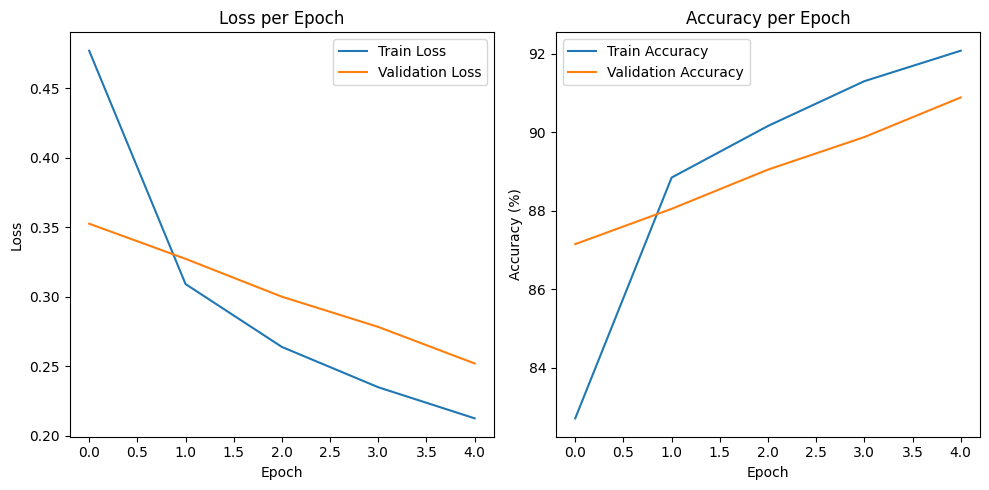

In [1]:
# 필요한 라이브러리와 모듈을 임포트합니다.
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Fashion-MNIST 데이터셋을 로드합니다.
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환합니다.
    transforms.Normalize((0.5,), (0.5,))  # 이미지를 정규화합니다.
])

# 데이터셋을 다운로드하고 변환을 적용합니다.
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 훈련 및 테스트 데이터를 로딩하기 위한 DataLoader를 생성합니다.
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# 간단한 CNN 모델을 정의합니다.
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  # 첫 번째 컨볼루션 레이어
        self.pool = nn.MaxPool2d(2, 2)  # 맥스 풀링 레이어
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # 두 번째 컨볼루션 레이어
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # 완전 연결 레이어
        self.fc2 = nn.Linear(128, 10)  # 출력 레이어

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 첫 번째 레이어에 대한 컨볼루션, 활성화 함수 및 풀링 적용
        x = self.pool(F.relu(self.conv2(x)))  # 두 번째 레이어에 대한 컨볼루션, 활성화 함수 및 풀링 적용
        x = torch.flatten(x, 1)  # 완전 연결 레이어를 위해 텐서 플래튼
        x = F.relu(self.fc1(x))  # 완전 연결 레이어에 활성화 함수 적용
        x = self.fc2(x)  # 출력 계산
        return x

# 모델, 손실 함수 및 최적화기를 초기화합니다.
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()  # 분류를 위한 크로스 엔트로피 손실
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 최적화기

# 모델을 훈련하는 함수입니다.
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=5):
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    
    for epoch in range(epochs):
        # 훈련 단계
        model.train()
        train_loss = 0
        train_correct = 0
        total_train = 0
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        # 검증 단계
        model.eval()
        test_loss = 0
        test_correct = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                test_correct += (predicted == labels).sum().item()
                total_test += labels.size(0)
        
        # 평균 손실과 정확도 계산
        epoch_train_loss = train_loss / total_train
        epoch_train_acc = 100 * train_correct / total_train
        epoch_test_loss = test_loss / total_test
        epoch_test_acc = 100 * test_correct / total_test
        
        # 지표를 history 딕셔너리에 저장
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['test_loss'].append(epoch_test_loss)
        history['test_acc'].append(epoch_test_acc)
        
        print(f'Epoch {epoch + 1}/{epochs}: Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%')
    
    return history

# 훈련 및 검증 지표를 시각화하는 함수입니다.
def plot_metrics(history):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['test_loss'], label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['test_acc'], label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 모델을 훈련하고 결과를 시각화합니다.
history = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=5)
plot_metrics(history)
